# Somativa 1 - Renato Curvelo
## Previsão de quantas bicicletas serão alugadas dependendo do dia e outras variáveis.
### Escolhi para o trabalho os de dados de aluguel de bicicletas em Seul.

In [26]:
import warnings
import pandas as pd #essa é indispensável
import seaborn as sns #para conseguir visualziar melhor o que estou procurando
import xgboost as xgb #uma tentativa de prever 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Rectangle
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

### _Para iniciar o trabalho..._
* Primeiro passo é ler o aquivo e dar uma olhada no que temos

In [28]:
df = pd.read_excel('seoul_bike_data.xlsx')
df.shape

(8760, 13)

* Um data set com várias instâncias e muitas informações... isso vai ser divertido

In [5]:
df.describe()

,Day,Weekday,Hour,Rented Bike Count,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,15.720548,3.980822,11.500000,704.602055,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,8.796749,2.004811,6.922582,644.997468,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,1.000000,1.000000,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,8.000000,2.000000,5.750000,191.000000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,16.000000,4.000000,11.500000,504.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,23.000000,6.000000,17.250000,1065.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,31.000000,7.000000,23.000000,3556.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


* Passando os olhos nas médias e quartis, Seul tem um clima ameno no geral e raramente chove ou neva

In [52]:
df.head()

,DateTime,Day,Weekday,Hour,Rented Bike Count,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
0,2017-01-12 00:00:00,12,5,0,254,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0
1,2017-01-12 01:00:00,12,5,1,204,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0
2,2017-01-12 02:00:00,12,5,2,173,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0
3,2017-01-12 03:00:00,12,5,3,107,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0
4,2017-01-12 04:00:00,12,5,4,78,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0


* Além da coluna com a data e hora, já temos outras com dados mais específicos, como o dia da semana, hora e etc. Isto é, a parte que interessa; ☝️ 

* Vou converter essa coluna para datetime, senão a correlação dos dados não funciona;

* Adicionei uma coluna com o mês separadamente, para analisar melhor se isso influencia. 👇

In [30]:
df['DateTime'] = pd.to_datetime(df['DateTime'])
df['Month'] = df['DateTime'].dt.month
df.tail()

,DateTime,Day,Weekday,Hour,Rented Bike Count,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Month
8755,2018-12-31 19:00:00,31,2,19,163,0.0,31,2.2,2000,-15.1,0.0,0.0,0.0,12
8756,2018-12-31 20:00:00,31,2,20,161,-1.0,32,0.9,2000,-15.6,0.0,0.0,0.0,12
8757,2018-12-31 21:00:00,31,2,21,179,-1.6,35,1.0,2000,-15.1,0.0,0.0,0.0,12
8758,2018-12-31 22:00:00,31,2,22,155,-2.1,36,1.7,2000,-15.2,0.0,0.0,0.0,12
8759,2018-12-31 23:00:00,31,2,23,227,-2.6,40,0.6,2000,-14.3,0.0,0.0,0.0,12


### *Preparação dos dados*
* Para isso, o primeiro passo é selecionar quais desses atributos são relevantes para influenciar a quantidade de bicicletas alugadas.

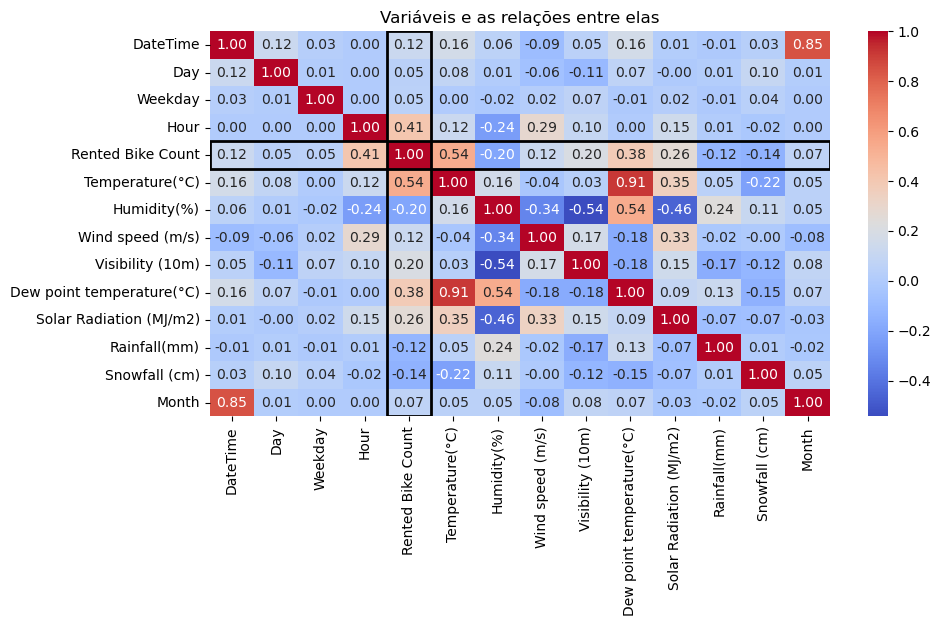

In [32]:
plt.figure(figsize=(10, 5))
ax = sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
ax.add_patch(Rectangle((0, 4), len(df.columns), 1, edgecolor='black', fill=False, lw=2))
ax.add_patch(Rectangle((4, 0), 1, len(df.columns), edgecolor='black', fill=False, lw=2))
plt.title("Variáveis e as relações entre elas")
plt.show()

* Opcionalmente, analisando a distribução dessas variáveis, para ver se cabe alguma normalização.

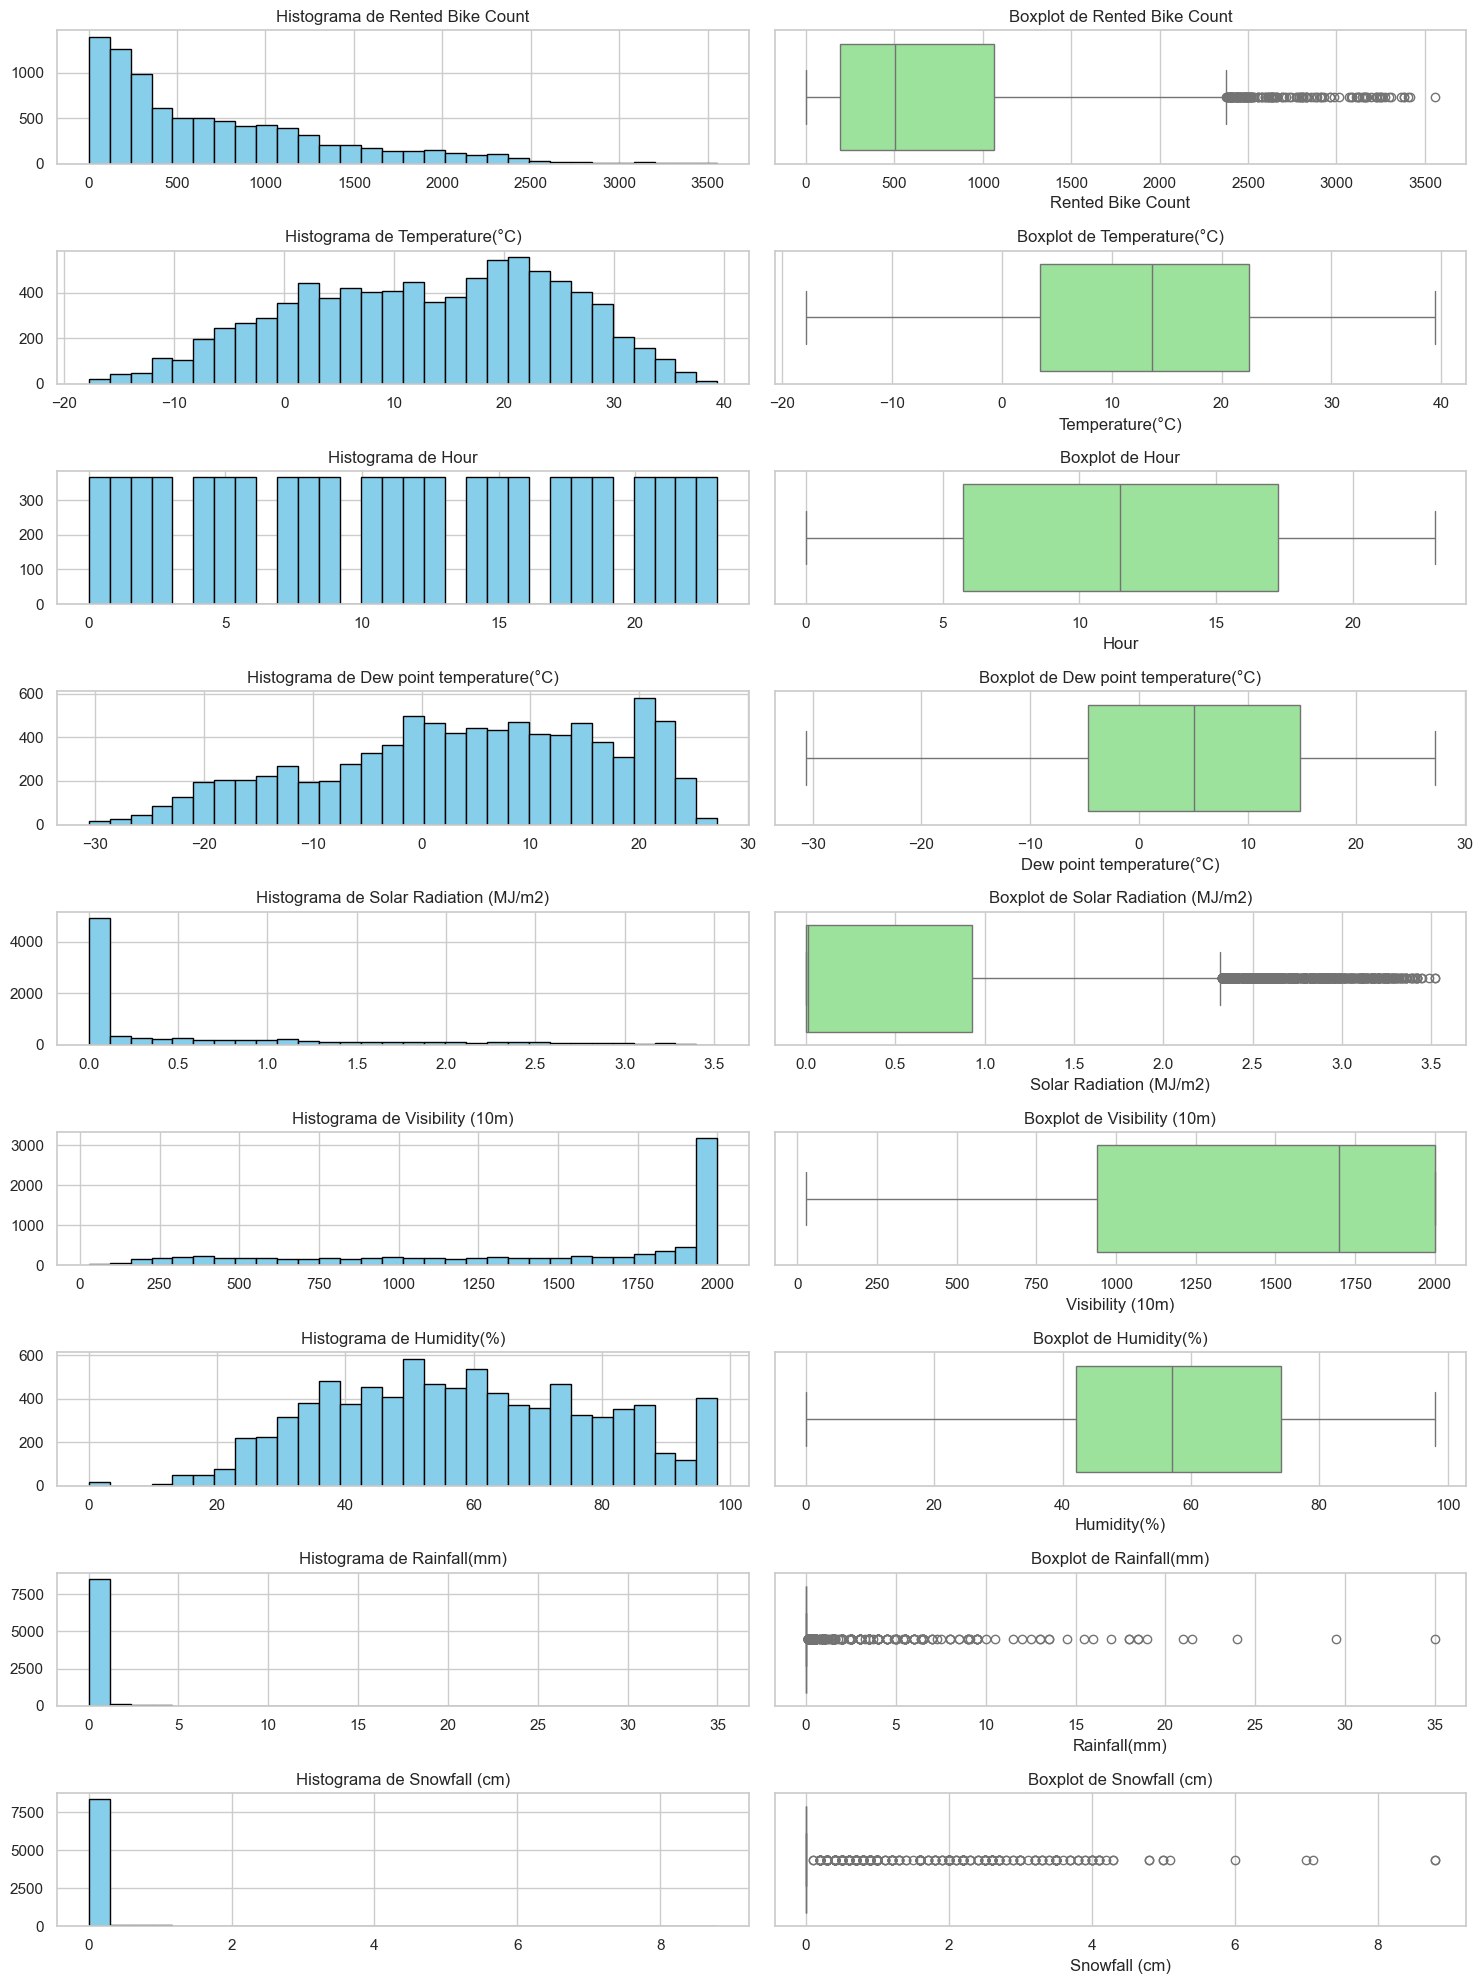

In [38]:
# Selecionar apenas as variáveis mais correlacionadas 
colunas_selecionadas = ['Rented Bike Count', 'Temperature(°C)', 'Hour', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 'Visibility (10m)', 'Humidity(%)', 'Rainfall(mm)', 'Snowfall (cm)']
df_reduzido = df[colunas_selecionadas]
sns.set(style="whitegrid")
plt.figure(figsize=(15, 20))
numeric_columns = df_reduzido.select_dtypes(['float64', 'int64']).columns

for i, column in enumerate(numeric_columns, 1):
    plt.subplot(len(numeric_columns), 2, 2 * i - 1)  # Subplot para histograma
    plt.hist(df_reduzido[column].dropna(), bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Histograma de {column}')

    plt.subplot(len(numeric_columns), 2, 2 * i)  # Subplot para box plot
    sns.boxplot(x=df_reduzido[column], color='lightgreen')
    plt.title(f'Boxplot de {column}')

plt.tight_layout()
plt.show()

* É possível observar outliers, mas estão relacionados ao fato de nevar, chover ou fazer dias muito quentes raramente no ano. ☝️ 
* Abaixo fiz uma soma dos valores por dia, para verificar se existe alguma outra correlação que não seja por hora. 👇

In [16]:
df['data'] = df['DateTime'].dt.date
total_diario = df.groupby('data')['Rented Bike Count'].sum().reset_index()
total_diario['data'] = pd.to_datetime(total_diario['data'])
total_diario['dia'] = total_diario['data'].dt.day
total_diario['dia_da_semana'] = total_diario['data'].dt.weekday
print(total_diario)

          data  Rented Bike Count  dia  dia_da_semana
0   2017-01-12               9539   12              3
1   2017-02-12               8523   12              6
2   2017-03-12               7222   12              6
3   2017-04-12               8729   12              2
4   2017-05-12               8307   12              4
..         ...                ...  ...            ...
360 2018-12-27               5351   27              3
361 2018-12-28               6594   28              4
362 2018-12-29               7663   29              5
363 2018-12-30               4027   30              6
364 2018-12-31               3423   31              0

[365 rows x 4 columns]


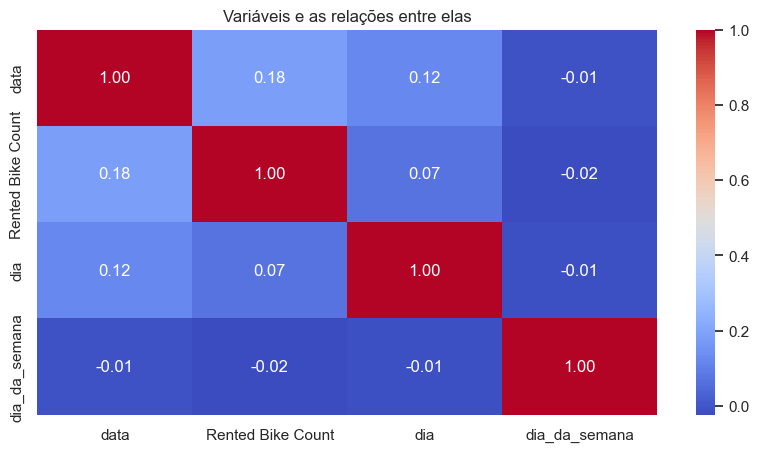

In [18]:
plt.figure(figsize=(10, 5))
sns.heatmap(total_diario.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Variáveis e as relações entre elas")
plt.show()

* Comparei o valor somado total diário com o dia do mês e o dia da semana, mas pelo visto sem relações diretas ☝️ 
* Abaixo um gráfico 3D com as variáveis mais "quentes" na relação 👇
* É possível observar que conforme a temperatura das tardinhas e noites é maior, geralmetne também sobe o número de bicicletas alugadas.

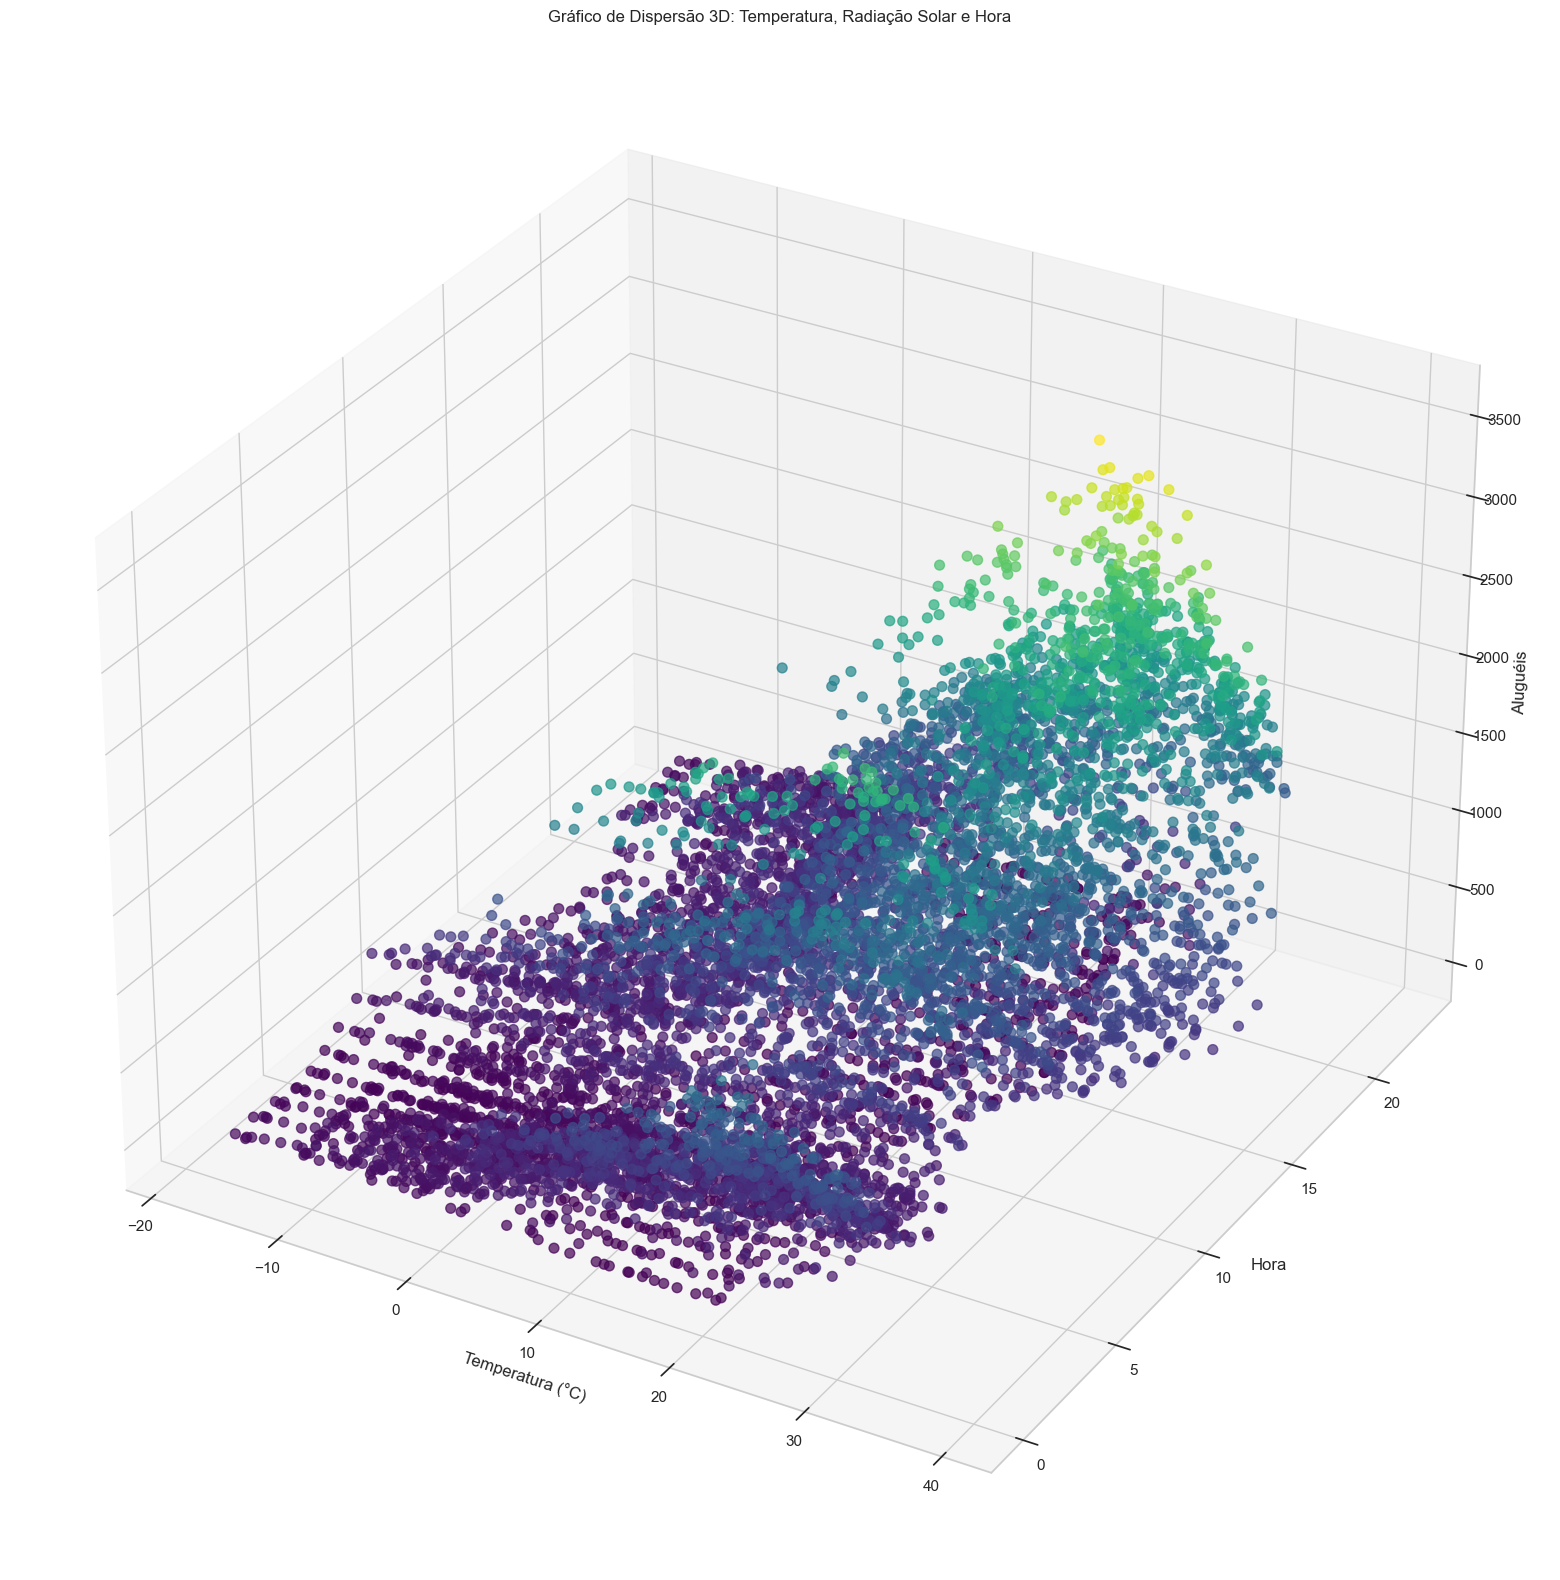

In [50]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

# Plotando os dados
ax.scatter(df_reduzido['Temperature(°C)'], df_reduzido['Hour'], df_reduzido['Rented Bike Count'], c=df_reduzido['Rented Bike Count'], cmap='viridis', s=50, alpha=0.7)

# Rótulos dos eixos
ax.set_xlabel("Temperatura (°C)")
ax.set_ylabel("Hora")
ax.set_zlabel("Aluguéis")

# Título do gráfico
ax.set_title("Gráfico de Dispersão 3D: Temperatura, Radiação Solar e Hora")

plt.show()

# Tipo do problema
## 5. Se trata de uma previsão de séries temporais com uso de regressão.

- *Previsão de Séries Temporais:* Para prever a quantidade de bicicletas em um dia futuro específico, o modelo precisa considerar a sequência e padrões ao longo do tempo (horário do aluguel, temperatura no momento e etc).

- *Regressão:* O valor de saída (quantidade de bicicletas alugadas) é uma variável contínua. Isso mostra que se trata de um problema de regressão.

## Abaixo duas tentativas diferentes de fazer essa previsão.
* 1 Usando o XGBoost
* 2 Usando o scikit-learn

In [61]:
# Separar as variáveis independentes (features) e a variável dependente (target)
X = df_reduzido.drop(columns=["Rented Bike Count"])
y = df_reduzido["Rented Bike Count"]

# Dividir o dataset em 75% para treino e 25% para teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Instanciar o modelo XGBoost com algumas configurações básicas
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=100)

# Treinar o modelo nos dados de treino
model.fit(X_train, y_train)

# Fazer previsões nos dados de teste
y_pred = model.predict(X_test)

# Avaliação do modelo
rmse = mean_squared_error(y_test, y_pred, squared=False)  
mae = mean_absolute_error(y_test, y_pred)

print(y_pred)

[1561.572    749.84515  696.9296  ...  788.45105  225.969    476.02847]


In [63]:
# Comparar previsões com os valores reais
predicoes_df = pd.DataFrame({'Valor Real': y_test, 'Predição': y_pred})
print(predicoes_df)

      Valor Real     Predição
6056         963  1561.572021
5556         668   749.845154
5990         542   696.929626
7674        2034  1205.762573
3319        1115   507.640961
...          ...          ...
1129         989   835.344604
4315        2288  2806.817139
6008        1163   788.451050
3438          69   225.968994
208          546   476.028473

[2190 rows x 2 columns]


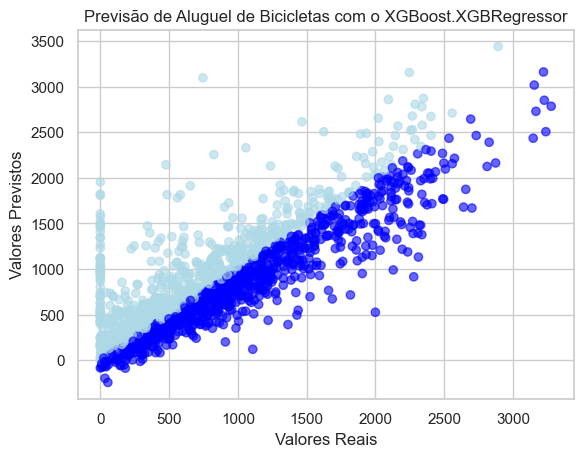

(313.85616386561776, 0.40700145842018964)

In [67]:
# Visualizando os resultados
colors = ['lightblue' if pred > true else 'blue' for pred, true in zip(y_pred, y_test)]

plt.scatter(y_test, y_pred, c=colors, alpha=0.6)
plt.xlabel("Valores Reais")
plt.ylabel("Valores Previstos")
plt.title("Previsão de Aluguel de Bicicletas com o XGBoost.XGBRegressor")
plt.grid(True)
plt.show()

# Resultados de avaliação
rmse, r2

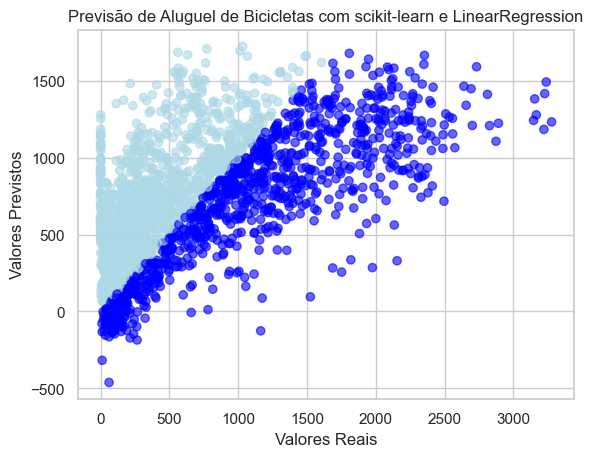

(498.24321716609586, 0.40700145842018964)

In [69]:
warnings.filterwarnings("ignore", category=FutureWarning)

# Preparação dos dados
# Selecionar apenas algumas colunas para simplificar o exemplo
# Supondo que "Rented Bike Count" é a variável alvo
data = df.copy()
target_column = "Rented Bike Count"  # Nome da coluna de saída
feature_columns = ["Temperature(°C)", "Humidity(%)", "Wind speed (m/s)", "Visibility (10m)",
                   "Dew point temperature(°C)", "Solar Radiation (MJ/m2)", "Rainfall(mm)", "Snowfall (cm)"]

# Filtrando apenas as colunas relevantes
data = data[feature_columns + [target_column]].dropna()

# Separação entre variáveis independentes e alvo
X = data[feature_columns]
y = data[target_column]

# Dividir o dataset em 75% para treino e 25% para teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Criação do modelo de regressão linear
model = LinearRegression()
model.fit(X_train, y_train)

# Previsões
y_pred = model.predict(X_test)

# Avaliação do modelo
rmse = mean_squared_error(y_test, y_pred, squared=False)  
mae = mean_absolute_error(y_test, y_pred)

rmse, mae

# Visualizando os resultados
colors = ['lightblue' if pred > true else 'blue' for pred, true in zip(y_pred, y_test)]

plt.scatter(y_test, y_pred, c=colors, alpha=0.6)
plt.xlabel("Valores Reais")
plt.ylabel("Valores Previstos")
plt.title("Previsão de Aluguel de Bicicletas com scikit-learn e LinearRegression")
plt.grid(True)
plt.show()

# Resultados de avaliação
rmse, r2
